In [1]:
#Beating rate, 90% or 80% contraction amplitude, dp/dt, TTP, time to 90% relaxtion, tau
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, butter, filtfilt,firwin
from scipy.integrate import simps
import os
from scipy.ndimage import median_filter


In [2]:
def moving_average(signal, window_size=4):
    return np.convolve(signal, np.ones(window_size)/window_size, mode='same')

def preprocess_full_moving_avg(contraction_stress, frame_time_point, window_size=4, display=False):
    """
    Apply full moving average to the contraction stress signal.
    """
    frame_time_point_sec = frame_time_point / 100
    filtered = moving_average(contraction_stress, window_size=window_size)

    if display:
        plt.figure(figsize=(12, 6))
        plt.plot(frame_time_point_sec, contraction_stress, label='Original', linestyle=':', alpha=0.5)
        plt.plot(frame_time_point_sec, filtered, label='Full Moving Avg', color='blue')
        plt.title('Full Moving Average Smoothing', fontsize=14)
        plt.xlabel('Time (s)')
        plt.ylabel('Contraction Stress (mN / mm²)')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    return filtered


def preprocess_selective_moving_avg(contraction_stress, frame_time_point, window_size=4, threshold_std=1.5, display=False):
    """
    Apply moving average only to regions without sharp transitions.
    """
    frame_time_point_sec = frame_time_point / 100
    derivative = np.abs(np.diff(contraction_stress, prepend=contraction_stress[0]))
    sharp_threshold = np.mean(derivative) + threshold_std * np.std(derivative)
    smooth_mask = derivative < sharp_threshold

    smoothed = moving_average(contraction_stress, window_size=window_size)
    filtered = contraction_stress.copy()
    filtered[smooth_mask] = smoothed[smooth_mask]

    if display:
        plt.figure(figsize=(12, 6))
        plt.plot(frame_time_point_sec, contraction_stress, label='Original', linestyle=':', alpha=0.5)
        plt.plot(frame_time_point_sec, filtered, label='Selective Moving Avg (no sharp zones)', color='orange')
        plt.title('Selective Moving Average (Avoids Sharp Transitions)', fontsize=14)
        plt.xlabel('Time (s)')
        plt.ylabel('Contraction Stress (mN / mm²)')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    return filtered

def preprocess_moving_median(contraction_stress, frame_time_point, window_size=5, display=False):
    """
    Apply moving median filter to the contraction stress signal.
    
    Parameters:
        contraction_stress (array): Input signal.
        frame_time_point (array): Frame times (in 1/100 sec units).
        window_size (int): Window size for the median filter (should be odd).
        display (bool): Whether to plot the result.

    Returns:
        filtered (array): Median-filtered signal.
    """
    frame_time_point_sec = frame_time_point / 100
    filtered = median_filter(contraction_stress, size=window_size)

    if display:
        plt.figure(figsize=(12, 6))
        plt.plot(frame_time_point_sec, contraction_stress, label='Original', linestyle=':', alpha=0.5)
        plt.plot(frame_time_point_sec, filtered, label='Moving Median Filter', color='purple')
        plt.title('Moving Median Filter Smoothing', fontsize=14)
        plt.xlabel('Time (s)')
        plt.ylabel('Contraction Stress (mN / mm²)')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    return filtered


In [3]:
def compute_signal_gradient(signal, time_vector, display=False, label='Signal'):
    """
    Compute the first derivative (gradient) of a signal over time.
    
    Parameters:
        signal (array): The signal to differentiate.
        time_vector (array): Time points corresponding to the signal.
        display (bool): If True, plot the signal and its gradient.
        label (str): Label for the signal in the plot (optional).
        
    Returns:
        gradient (array): The gradient of the signal.
    """
    gradient = np.gradient(signal, time_vector)

    if display:
        fig, axs = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

        # Plot original signal
        axs[0].plot(time_vector, signal, label=label, color='green')
        axs[0].set_ylabel('Signal Amplitude')
        axs[0].set_title('Original Signal')
        axs[0].legend()
        axs[0].grid(True)

        # Plot gradient
        axs[1].plot(time_vector, gradient, label='Gradient', color='purple')
        axs[1].set_xlabel('Time (s)')
        axs[1].set_ylabel('d(signal)/dt')
        axs[1].set_title('Signal Gradient (1st Derivative)')
        axs[1].legend()
        axs[1].grid(True)

        plt.tight_layout()
        plt.show()

    return gradient


In [4]:
def detect_contraction_rise_points(signal, time_vector, gradient_prominence=2, min_peak_distance=20, display=False):
    """
    Detect contraction rise points by finding gradient peaks (max slope)
    and the first preceding point where gradient changes from negative to positive.

    Parameters:
        signal (array): Filtered signal.
        time_vector (array): Corresponding time in seconds.
        gradient_prominence (float): Prominence threshold for gradient peaks.
        min_peak_distance (int): Minimum distance between peaks (in samples).
        display (bool): If True, plot the signal with detected points.

    Returns:
        zero_crossings (list): Indices where ∇ changes from negative to positive before rise peak.
    """
    gradient = np.gradient(signal, time_vector)

    # Step 1: Detect strong rising slopes (positive peaks in gradient)
    grad_peaks, _ = find_peaks(gradient, prominence=gradient_prominence, distance=min_peak_distance)

    # Step 2: For each peak, find first local min (∇ changes sign upward) before it
    zero_crossings = []
    for peak_idx in grad_peaks:
        for i in range(peak_idx - 1, 1, -1):
            if gradient[i - 1] < 0 and gradient[i] >= 0:
                zero_crossings.append(i)
                break

    if display:
        plt.figure(figsize=(12, 6))
        plt.plot(time_vector, signal, label='Filtered Signal', color='green')
        plt.plot(time_vector[zero_crossings], signal[zero_crossings], 'bo', label='Start Activation (∇ crosses up)')
        plt.title('Detected Contraction Rise Points')
        plt.xlabel('Time (s)')
        plt.ylabel('Contraction Stress (mN / mm²)')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    return zero_crossings


In [5]:
def calculate_beating_rate(peak_indices, time_vector, display=True):
    """
    Calculate beating rate (BPM) and frequency (Hz) from peak indices.

    Parameters:
        peak_indices (array): Indices of detected peaks.
        time_vector (array): Time in seconds corresponding to signal samples.
        display (bool): If True, print BPM and frequency.

    Returns:
        bpm (float): Beating rate in beats per minute.
        freq_hz (float): Beating frequency in Hz.
        time_intervals (array): Time between beats (seconds).
    """
    if len(peak_indices) < 2:
        if display:
            print("Not enough peaks to calculate beating rate.")
        return None, None, []

    # Get time values at peaks
    peak_times = time_vector[peak_indices]

    # Calculate intervals and statistics
    time_intervals = np.diff(peak_times)
    avg_interval = np.mean(time_intervals)
    bpm = int(60 / avg_interval)
    freq_hz = 1 / avg_interval

    if display:
        print(f"Beating Rate: {bpm} BPM")
        print(f"Calculated Frequency: {freq_hz:.2f} Hz")

    return bpm, freq_hz, time_intervals


In [6]:
# def compute_relative_contraction_amplitudes(signal, peaks, end_relax_idxs, threshold_percentage=0.9, display=True):
#     """
#     Compute per-cycle relative contraction amplitudes (e.g. 90% of peak rise) from end-of-relaxation to peak.

#     Ensures that the first relax index is before the first peak,
#     and the last peak is before the last relax index.

#     Parameters:
#         signal (array): The filtered contraction signal.
#         peaks (array): Indices of contraction peaks.
#         end_relax_idxs (array): Indices of relaxation end points.
#         threshold_percentage (float): Fraction of full amplitude to extract (default 0.9).
#         display (bool): If True, print amplitudes and summary.

#     Returns:
#         cycle_amplitudes (list): Full peak-to-start amplitudes.
#         cycle_amplitudes_90 (list): 90% amplitude values per cycle.
#         mean_90 (float): Mean 90% amplitude across all valid cycles.
#     """
#     # Ensure arrays
#     peaks = np.array(peaks)
#     end_relax_idxs = np.array(end_relax_idxs)

#     # Align: first relax < first peak, last peak < last relax
#     if end_relax_idxs[0] > peaks[0]:
#         peaks = peaks[1:]
#     if peaks[-1] > end_relax_idxs[-1]:
#         peaks = peaks[:-1]

#     # Trim to equal length
#     min_len = min(len(peaks), len(end_relax_idxs))
#     peaks = peaks[:min_len]
#     end_relax_idxs = end_relax_idxs[:min_len]

#     cycle_amplitudes = []
#     cycle_amplitudes_90 = []

#     for i, (peak, relax) in enumerate(zip(peaks, end_relax_idxs)):
#         if relax < peak:
#             amp = signal[peak] - signal[relax]
#             cycle_amplitudes.append(amp)
#             cycle_amplitudes_90.append(amp * threshold_percentage)
#             if display:
#                 print(f"Cycle {i+1}: Full Amplitude = {amp:.3f}, {threshold_percentage*100:.0f}% = {amp * threshold_percentage:.3f}")
#         elif display:
#             print(f"Cycle {i+1}: Skipped (relax {relax} not before peak {peak})")

#     mean_90 = np.mean(cycle_amplitudes_90) if cycle_amplitudes_90 else None

#     if display:
#         print(f"\nMean {threshold_percentage*100:.0f}% contraction amplitude: {mean_90:.3f}" if mean_90 else "No valid contraction cycles found.")

#     return cycle_amplitudes, cycle_amplitudes_90, mean_90


In [50]:
def compute_relative_contraction_amplitudes_to_baseline(signal, peaks, baseline_per_cycle,
                                                        threshold_percentage=0.9, display=True):
    """
    Compute contraction amplitudes from peak to baseline per cycle, and derive threshold-based amplitudes (e.g., 90%).

    Parameters:
        signal (array): The filtered contraction signal.
        peaks (array): Indices of contraction peaks, aligned to baseline_per_cycle.
        baseline_per_cycle (list or array): Baseline signal value per cycle.
        threshold_percentage (float): Fraction of peak-to-baseline amplitude (e.g., 0.9 = 90%).
        display (bool): If True, print amplitude per cycle and mean.

    Returns:
        full_amplitudes (list): Peak-to-baseline amplitudes.
        threshold_amplitudes (list): threshold_percentage amplitudes per cycle.
        mean_threshold_amp (float): Mean of threshold_percentage amplitudes.
    """
    peaks = np.array(peaks)
    baseline_per_cycle = np.array(baseline_per_cycle)

    assert len(peaks) == len(baseline_per_cycle), "Mismatch: peaks and baseline_per_cycle must be aligned"

    full_amplitudes = []
    threshold_amplitudes = []

    for i, (peak_idx, baseline_val) in enumerate(zip(peaks, baseline_per_cycle)):
        peak_val = signal[peak_idx]
        amp = peak_val - baseline_val
        full_amplitudes.append(amp)
        threshold_amplitudes.append(amp * threshold_percentage)

        if display:
            print(f"Cycle {i+1}: Amplitude = {amp:.3f}, {int(threshold_percentage*100)}% = {amp * threshold_percentage:.3f}")

    mean_threshold_amp = np.mean(threshold_amplitudes) if threshold_amplitudes else None

    if display:
        if mean_threshold_amp is not None:
            print(f"\nMean {int(threshold_percentage*100)}% contraction amplitude: {mean_threshold_amp:.3f}")
        else:
            print("No valid contraction cycles found.")

    return full_amplitudes, threshold_amplitudes, mean_threshold_amp


In [37]:
def compute_time_to_peak(time_vector, peaks, start_activation_idx, display=False):
    """
    Compute time-to-peak (TTP) from activation onset to the next peak for each contraction cycle.

    Ensures first activation comes before first peak, and last peak before last activation.

    Parameters:
        time_vector (array): Time values in seconds.
        peaks (array): Indices of contraction peaks.
        start_activation_idx (array): Indices where the signal starts to rise (activation).
        display (bool): If True, print TTP values.

    Returns:
        time_to_peaks (list): Time to peak per cycle (s).
        mean_ttp (float): Mean TTP across valid cycles.
    """
    peaks = np.array(peaks)
    start_activation_idx = np.array(start_activation_idx)

    # Align activation indices with peaks
    if start_activation_idx[0] > peaks[0]:
        peaks = peaks[1:]
    if peaks[-1] > start_activation_idx[-1]:
        peaks = peaks[:-1]

    min_len = min(len(peaks), len(start_activation_idx))
    peaks = peaks[:min_len]
    start_activation_idx = start_activation_idx[:min_len]

    time_to_peaks = []

    for i, (peak_idx, activation_idx) in enumerate(zip(peaks, start_activation_idx)):
        if activation_idx < peak_idx:
            ttp = time_vector[peak_idx] - time_vector[activation_idx]
            time_to_peaks.append(ttp)
            if display:
                print(f"Cycle {i+1}: Time to Peak = {ttp:.3f} s")
        elif display:
            print(f"Cycle {i+1}: Skipped (activation idx {activation_idx} not before peak idx {peak_idx})")

    mean_ttp = np.mean(time_to_peaks) if time_to_peaks else None

    if display:
        print(f"\nMean Time to Peak: {mean_ttp:.3f} s" if mean_ttp is not None else "No valid cycles found.")

    return time_to_peaks, mean_ttp


In [8]:
def detect_contraction_relaxation_end_points(signal, time_vector, gradient_prominence=2, min_peak_distance=20, display=False):
    """
    Detect true end of contraction relaxation: find local minima in the gradient where the
    derivative changes sign from negative to positive.

    Parameters:
        signal (array): Filtered contraction signal.
        time_vector (array): Time vector in seconds.
        gradient_prominence (float): Prominence threshold for gradient troughs.
        min_peak_distance (int): Minimum spacing between detected minima.
        display (bool): If True, plot result.

    Returns:
        relax_end_points (list): Indices of points where gradient changes from negative to positive.
    """
    gradient = np.gradient(signal, time_vector)

    # Step 1: Find troughs (steepest downward slopes)
    grad_troughs, _ = find_peaks(-gradient, prominence=gradient_prominence, distance=min_peak_distance)

    relax_end_points = []

    # Step 2: For each trough, find where the gradient crosses zero upward (local min)
    for trough_idx in grad_troughs:
        for i in range(trough_idx + 1, len(gradient) - 1):
            if gradient[i] <= 0 and gradient[i + 1] > 0:
                relax_end_points.append(i)
                break

    if display:
        plt.figure(figsize=(12, 6))
        plt.plot(time_vector, signal, label='Filtered Signal', color='black')
        plt.plot(time_vector[relax_end_points], signal[relax_end_points], 'bo', label='End of Relaxation (∇ changes sign)')
        plt.title('True End of Relaxation Points (Local Minima in ∇)')
        plt.xlabel('Time (s)')
        plt.ylabel('Contraction Stress (mN/mm²)')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    return relax_end_points


In [9]:
file_name = "stress_1HZ_3_flood_fill.csv"
df =  pd.read_csv(file_name)
contraction_stress, frame_time_point = df['stress_kpa'] , df['frame']

In [10]:
frame_rate_per_sec = 100
frame_time_point_sec = frame_time_point / 100

In [11]:
# === Apply both filters ===
filtered_full = preprocess_moving_median(contraction_stress, frame_time_point, window_size=3, display=False)
filtered_full = preprocess_full_moving_avg(filtered_full, frame_time_point, window_size=4, display=False)

filtered_selective = preprocess_selective_moving_avg(contraction_stress, frame_time_point, window_size=4, display=False)


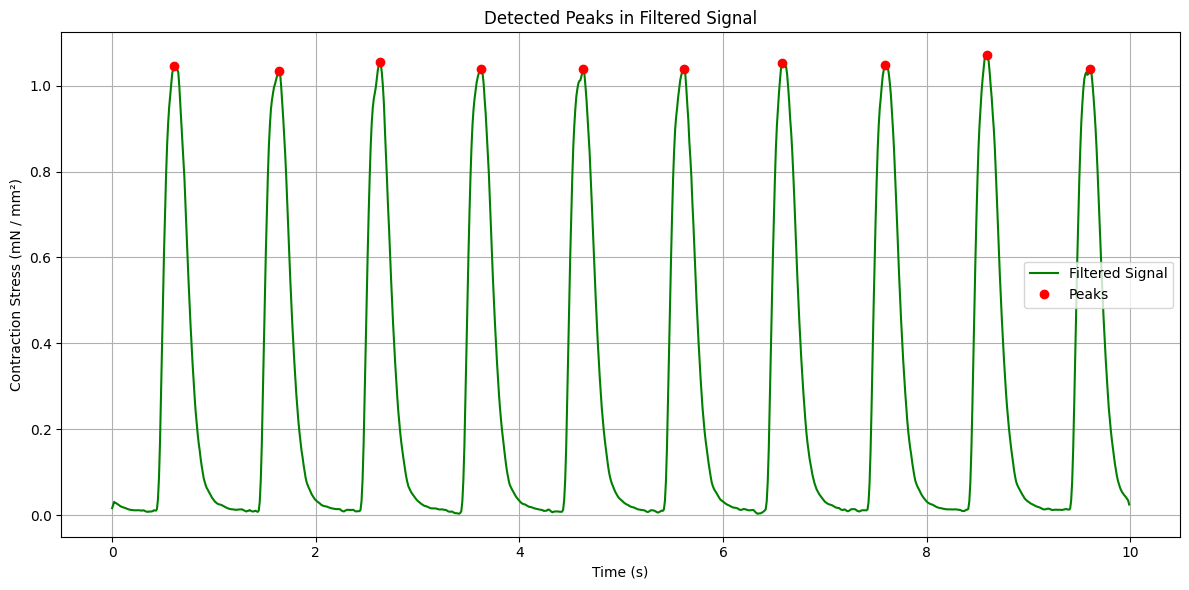

In [12]:
# === Find peaks ===
peaks, properties = find_peaks(filtered_full, prominence=0.1, distance=20)

# === Plot ===
plt.figure(figsize=(12, 6))
plt.plot(frame_time_point_sec, filtered_full, label='Filtered Signal', color='green')
plt.plot(frame_time_point_sec[peaks], filtered_full[peaks], 'ro', label='Peaks')
plt.title('Detected Peaks in Filtered Signal')
plt.xlabel('Time (s)')
plt.ylabel('Contraction Stress (mN / mm²)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

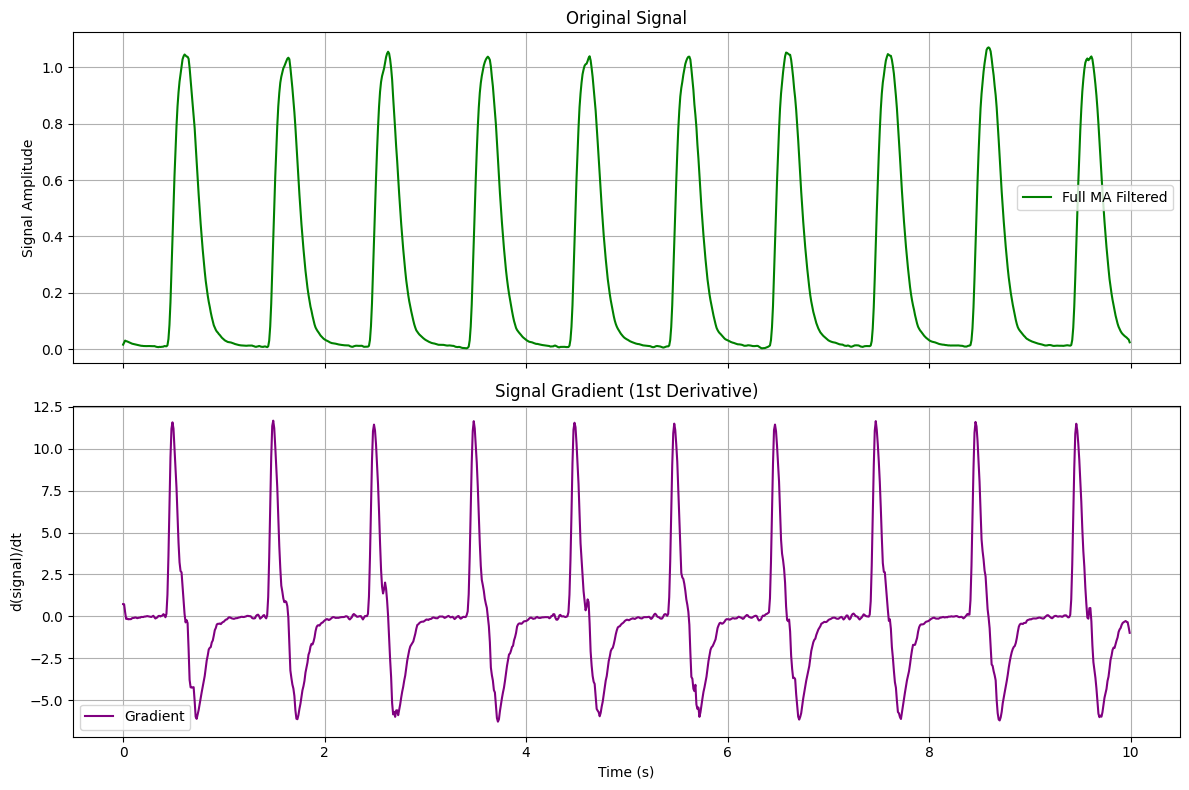

In [13]:
gradient_full = compute_signal_gradient(filtered_full, frame_time_point_sec, display=True, label='Full MA Filtered')
#gradient_selective = compute_signal_gradient(filtered_selective, frame_time_point_sec, display=True, label='selective MA Filtered')

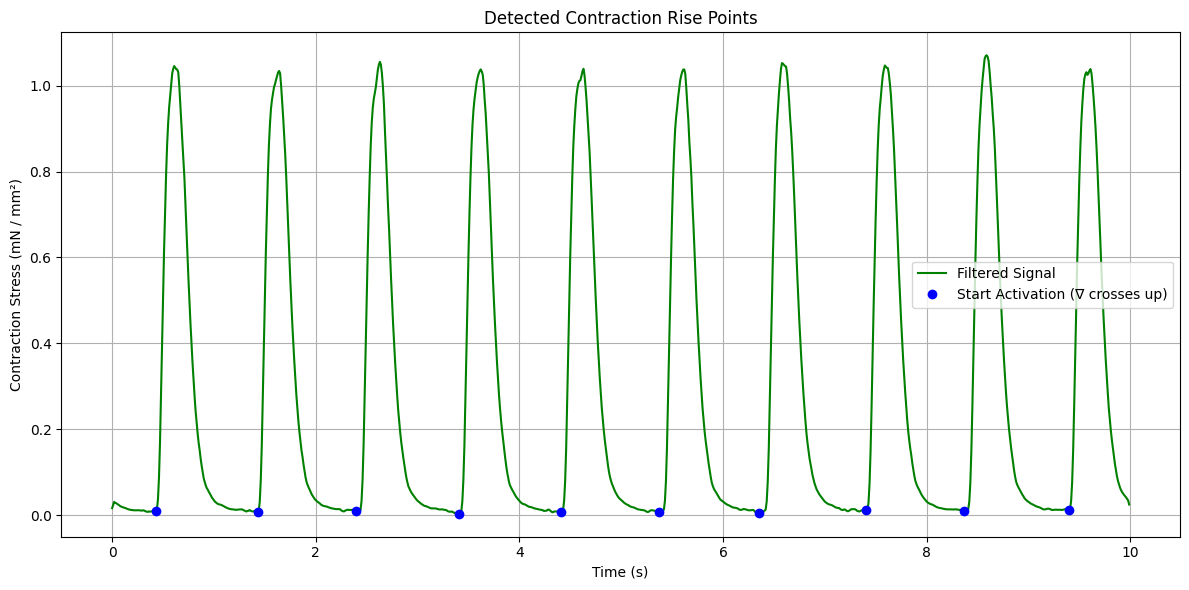

In [14]:
start_activation_idx = detect_contraction_rise_points(
    signal=filtered_full,
    time_vector=frame_time_point_sec,
    gradient_prominence=2,
    min_peak_distance=20,
    display=True
)

In [15]:
end_relax_idxs = detect_contraction_relaxation_end_points(
    signal=filtered_full,
    time_vector=frame_time_point_sec,
    gradient_prominence=2,
    min_peak_distance=20,
    display=False
)


In [16]:
def align_contraction_cycles(peaks, relax_idxs):
    """
    Align contraction cycles so that each cycle starts at a relaxation point,
    contains one peak, and ends at the next relaxation point.

    Parameters:
        peaks (array): Indices of contraction peaks.
        relax_idxs (array): Indices of relaxation end/start points.

    Returns:
        aligned_peaks (np.ndarray): One peak per cycle (between relax pairs).
        relax_pairs (list of tuples): Relaxation ranges per cycle.
    """
    peaks = np.array(peaks)
    relax_idxs = np.array(relax_idxs)

    if relax_idxs[0] > peaks[0]:
        peaks = peaks[1:]
    if relax_idxs[-1] < peaks[-1]:
        peaks = peaks[:-1]

    min_len = min(len(peaks), len(relax_idxs) - 1)
    aligned_peaks = peaks[:min_len]
    relax_pairs = list(zip(relax_idxs[:min_len], relax_idxs[1:min_len + 1]))

    return aligned_peaks, relax_pairs

Cycle 1: activation = [43 → 143], Peak = 61
Cycle 2: activation = [143 → 240], Peak = 164
Cycle 3: activation = [240 → 341], Peak = 263
Cycle 4: activation = [341 → 441], Peak = 362
Cycle 5: activation = [441 → 537], Peak = 463
Cycle 6: activation = [537 → 635], Peak = 562
Cycle 7: activation = [635 → 741], Peak = 658
Cycle 8: activation = [741 → 837], Peak = 759
Cycle 9: activation = [837 → 940], Peak = 859


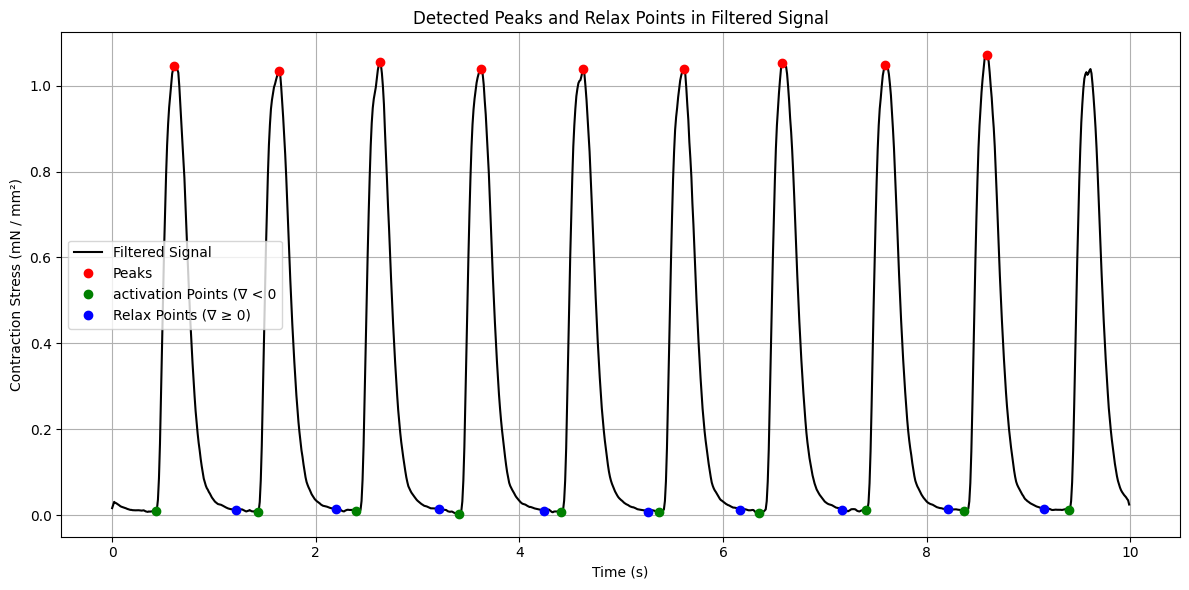

In [17]:

# === Run alignment ===
aligned_peaks, relax_pairs = align_contraction_cycles(peaks=peaks, relax_idxs=start_activation_idx)

# === Print aligned cycles ===
for i, (p, (r1, r2)) in enumerate(zip(aligned_peaks, relax_pairs)):
    print(f"Cycle {i+1}: activation = [{r1} → {r2}], Peak = {p}")

# === Plot ===
plt.figure(figsize=(12, 6))
plt.plot(frame_time_point_sec, filtered_full, label='Filtered Signal', color='black')
plt.plot(frame_time_point_sec[aligned_peaks], filtered_full[aligned_peaks], 'ro', label='Peaks')
plt.plot(frame_time_point_sec[start_activation_idx], filtered_full[start_activation_idx], 'o', color='green', label='activation Points (∇ < 0')
plt.plot(frame_time_point_sec[end_relax_idxs], filtered_full[end_relax_idxs], 'o', color='blue', label='Relax Points (∇ ≥ 0)')


plt.title('Detected Peaks and Relax Points in Filtered Signal')
plt.xlabel('Time (s)')
plt.ylabel('Contraction Stress (mN / mm²)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


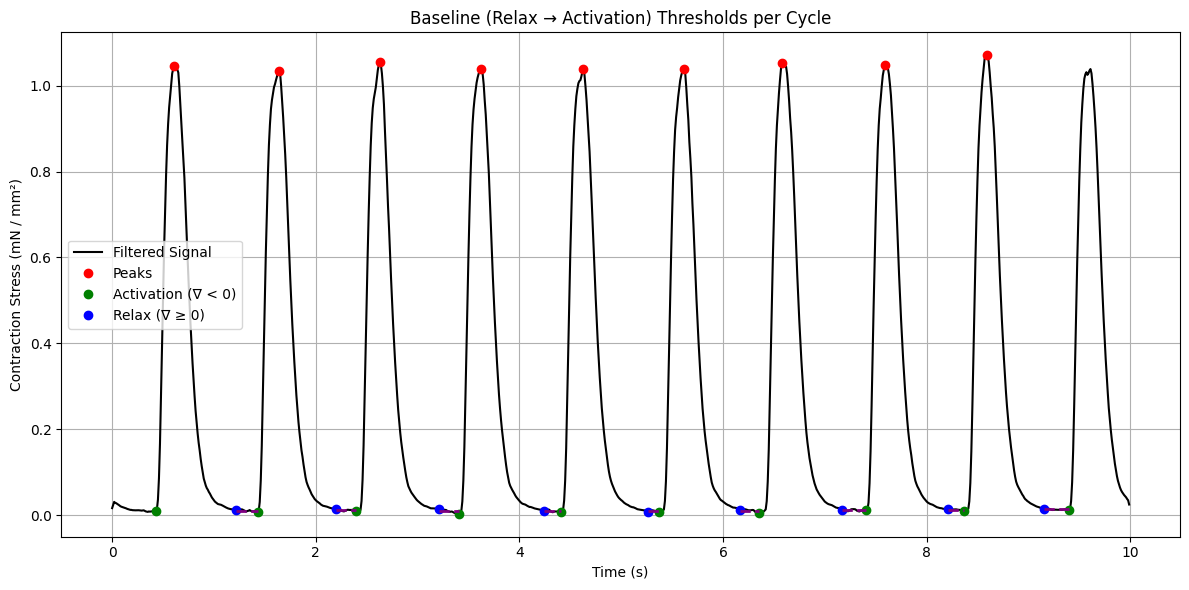

In [18]:
# --- Create relax → activation valid pairs ---
relax_idxs = np.array(end_relax_idxs)
activation_idxs = np.array(start_activation_idx)

valid_pairs = []
for r in relax_idxs:
    future_activations = activation_idxs[activation_idxs > r]
    if len(future_activations) > 0:
        a = future_activations[0]
        valid_pairs.append((r, a))

# --- Plot signal and relaxation threshold lines ---
plt.figure(figsize=(12, 6))
plt.plot(frame_time_point_sec, filtered_full, color='black', label='Filtered Signal')
plt.plot(frame_time_point_sec[aligned_peaks], filtered_full[aligned_peaks], 'ro', label='Peaks')
plt.plot(frame_time_point_sec[start_activation_idx], filtered_full[start_activation_idx], 'o', color='green', label='Activation (∇ < 0)')
plt.plot(frame_time_point_sec[end_relax_idxs], filtered_full[end_relax_idxs], 'o', color='blue', label='Relax (∇ ≥ 0)')


baseline_per_cycle = []
baseline_pairs = []
# Draw horizontal relaxation threshold lines
for r, a in valid_pairs:
    x1, x2 = frame_time_point_sec[r], frame_time_point_sec[a]
    segment = filtered_full[r:a+1]
    mean_val = np.mean(segment)
    plt.hlines(y=mean_val, xmin=x1, xmax=x2, colors='purple', linestyles='--', linewidth=2)
    baseline_per_cycle.append(mean_val)
    baseline_pairs.append((r, a))  # Keep matching indices for alignment
    

plt.title('Baseline (Relax → Activation) Thresholds per Cycle')
plt.xlabel('Time (s)')
plt.ylabel('Contraction Stress (mN / mm²)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [52]:
def compute_baseline_per_cycle(signal, time_vector, end_relax_idxs, start_activation_idx,
                                peaks=None, plot=True):
    """
    Compute per-cycle baselines between relaxation and the next activation point.
    Optionally plots the signal with baseline lines and peak markers.

    Parameters:
        signal (array): Filtered contraction signal.
        time_vector (array): Corresponding time values (seconds).
        end_relax_idxs (array): Indices of relaxation end points.
        start_activation_idx (array): Indices where next activation starts.
        peaks (array): Optional indices of contraction peaks (for plotting).
        plot (bool): If True, generate the plot.

    Returns:
        baseline_per_cycle (list): Mean value between each relax→activation interval.
        baseline_pairs (list of tuples): (relax_idx, activation_idx) per cycle.
    """
    relax_idxs = np.array(end_relax_idxs)
    activation_idxs = np.array(start_activation_idx)

    baseline_per_cycle = []
    baseline_pairs = []

    valid_pairs = []
    for r in relax_idxs:
        future_activations = activation_idxs[activation_idxs > r]
        if len(future_activations) > 0:
            a = future_activations[0]
            valid_pairs.append((r, a))

    if plot:
        plt.figure(figsize=(12, 6))
        plt.plot(time_vector, signal, color='black', label='Filtered Signal')

        if peaks is not None:
            plt.plot(time_vector[peaks], signal[peaks], 'ro', label='Peaks')
        plt.plot(time_vector[start_activation_idx], signal[start_activation_idx], 'o', color='green', label='Activation (∇ < 0)')
        plt.plot(time_vector[end_relax_idxs], signal[end_relax_idxs], 'o', color='blue', label='Relax (∇ ≥ 0)')

    for r, a in valid_pairs:
        segment = signal[r:a+1]
        mean_val = np.mean(segment)
        baseline_per_cycle.append(mean_val)
        baseline_pairs.append((r, a))
        
        if plot:
            x1, x2 = time_vector[r], time_vector[a]
            plt.hlines(y=mean_val, xmin=x1, xmax=x2, colors='purple', linestyles='--', linewidth=2)

    if plot:
        plt.title('Baseline (Relax → Activation) Thresholds per Cycle')
        plt.xlabel('Time (s)')
        plt.ylabel('Contraction Stress (mN / mm²)')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    return baseline_per_cycle, baseline_pairs


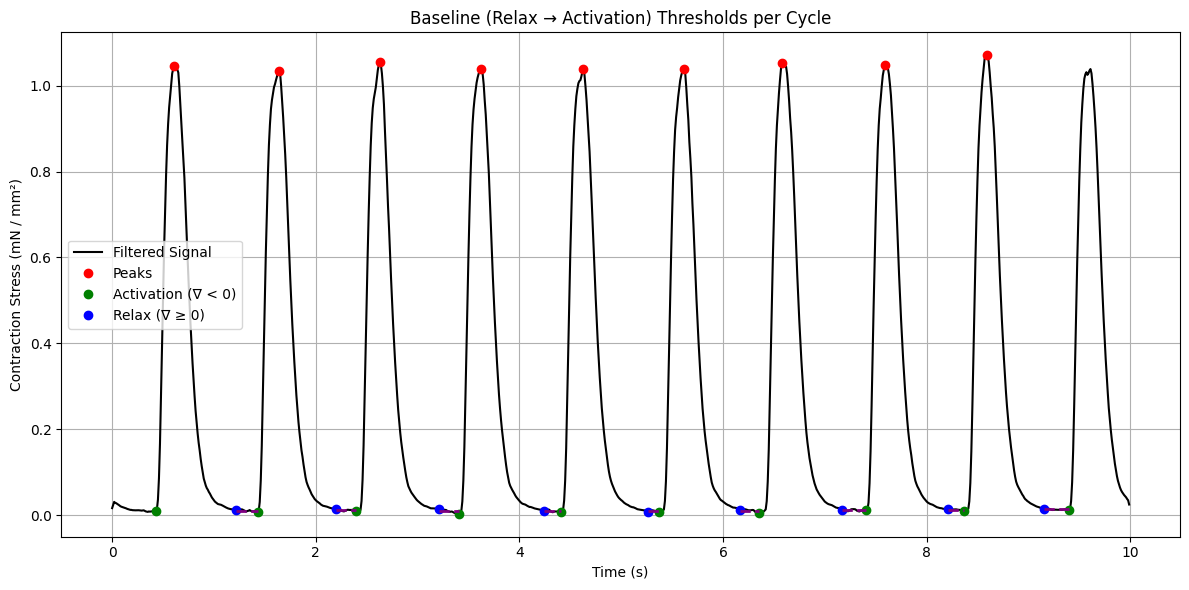

In [53]:
baseline_per_cycle, baseline_pairs = compute_baseline_per_cycle(
    signal=filtered_full,
    time_vector=frame_time_point_sec,
    end_relax_idxs=end_relax_idxs,
    start_activation_idx=start_activation_idx,
    peaks=aligned_peaks,   # optional
    plot=True
)


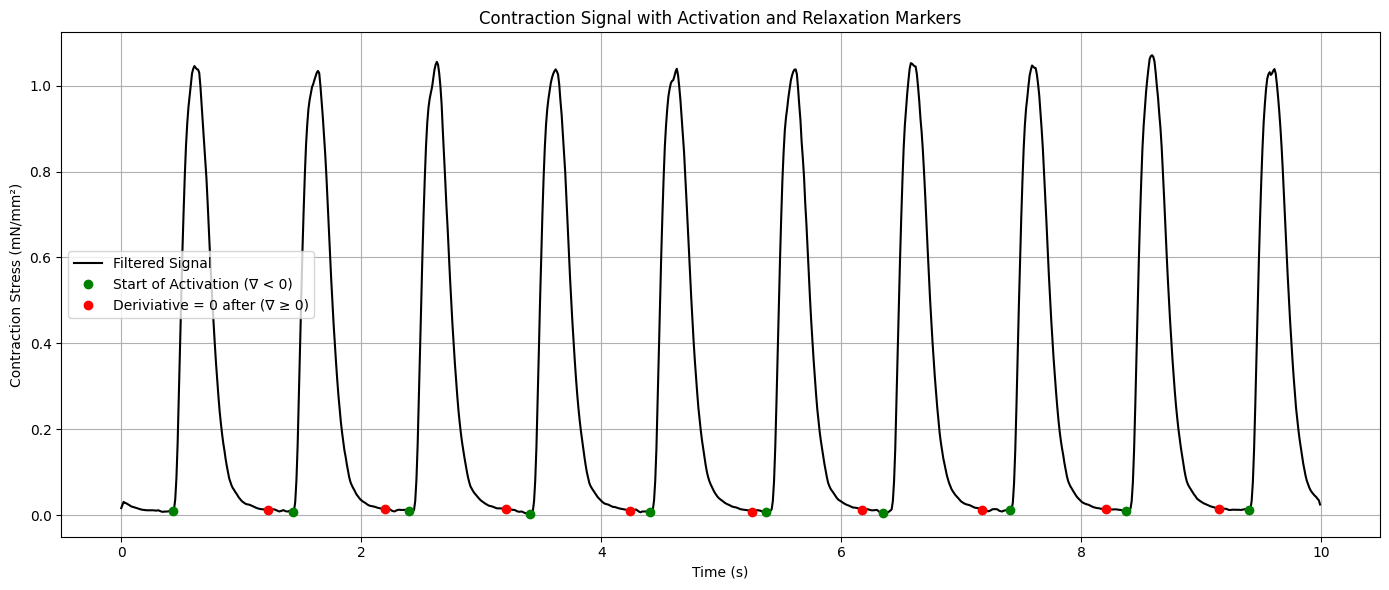

In [19]:
# Function to overlay both start-of-activation and end-of-relaxation points on the same signal
def plot_contraction_phases(signal, time_vector, start_idxs, end_idxs):
    plt.figure(figsize=(14, 6))
    plt.plot(time_vector, signal, label='Filtered Signal', color='black')

    plt.plot(time_vector[start_idxs], signal[start_idxs], 'go', label='Start of Activation (∇ < 0)')
    plt.plot(time_vector[end_idxs], signal[end_idxs], 'ro', label='Deriviative = 0 after (∇ ≥ 0)')

    plt.title('Contraction Signal with Activation and Relaxation Markers')
    plt.xlabel('Time (s)')
    plt.ylabel('Contraction Stress (mN/mm²)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Apply detection
start_activation_idx = detect_contraction_rise_points(
    signal=filtered_full,
    time_vector=frame_time_point_sec,
    gradient_prominence=2,
    min_peak_distance=20,
    display=False
)

end_relax_idxs = detect_contraction_relaxation_end_points(
    signal=filtered_full,
    time_vector=frame_time_point_sec,
    gradient_prominence=2,
    min_peak_distance=20,
    display=False
)

# Plot combined
plot_contraction_phases(filtered_full, frame_time_point_sec, start_activation_idx, end_relax_idxs)


In [20]:
def align_contraction_cycles(peaks, relax_idxs):
    """
    Align contraction cycles so that each cycle starts at a relaxation point,
    contains one peak, and ends at the next relaxation point.

    Parameters:
        peaks (array): Indices of contraction peaks.
        relax_idxs (array): Indices of end-of-relaxation points.

    Returns:
        aligned_peaks (np.ndarray): One peak per cycle.
        relax_pairs (list of tuples): List of (start_relax_idx, end_relax_idx) for each cycle.
    """
    peaks = np.array(peaks)
    relax_idxs = np.array(relax_idxs)

    # Step 1: Ensure first relax comes before first peak
    if relax_idxs[0] > peaks[0]:
        peaks = peaks[1:]

    # Step 2: Ensure last relax comes after last peak
    if relax_idxs[-1] < peaks[-1]:
        peaks = peaks[:-1]

    # # Step 3: Align by min length
    # min_len = min(len(peaks), len(relax_idxs) - 1)
    # aligned_peaks = peaks[:min_len]
    # relax_pairs = list(zip(relax_idxs[:min_len], relax_idxs[1:min_len+1]))

    return aligned_peaks


In [21]:
bpm, freq_hz, intervals = calculate_beating_rate(peaks, frame_time_point_sec, display=False)

In [22]:
amps, amps_90, mean_90 = compute_relative_contraction_amplitudes(
    signal=filtered_full,
    peaks=peaks,
    end_relax_idxs=end_relax_idxs,
    threshold_percentage=0.9,
    display=False
)


In [23]:
ttp_list, mean_ttp = compute_time_to_peak(frame_time_point_sec, peaks, end_relax_idxs, display=False)

In [39]:
# def compute_peak_to_90_relaxation_time(signal, time_vector, peaks, end_relax_idxs, threshold_percentage=0.9, display=True):
#     """
#     Compute the time from each peak to 90% relaxation level (within each contraction cycle).

#     Parameters:
#         signal (array): The filtered signal.
#         time_vector (array): Time in seconds.
#         peaks (array): Indices of contraction peaks.
#         end_relax_idxs (array): Indices of end-of-relaxation points.
#         threshold_percentage (float): Percentage of full relaxation (default 0.9 = 90% relaxation).
#         display (bool): If True, print results.

#     Returns:
#         t90r_times (list): Time from peak to 90% relaxation for each valid cycle.
#         mean_t90r (float): Mean time to 90% relaxation.
#     """
#     peaks = np.array(peaks)
#     end_relax_idxs = np.array(end_relax_idxs)

#     # Step 1: Align indices
#     if end_relax_idxs[0] < peaks[0]:
#         end_relax_idxs = end_relax_idxs[1:]
#     if peaks[-1] > end_relax_idxs[-1]:
#         peaks = peaks[:-1]

#     min_len = min(len(peaks), len(end_relax_idxs))
#     peaks = peaks[:min_len]
#     end_relax_idxs = end_relax_idxs[:min_len]

#     t90r_times = []

#     for i, (peak_idx, relax_idx) in enumerate(zip(peaks, end_relax_idxs)):
#         if relax_idx > peak_idx:
#             peak_val = signal[peak_idx]
#             relax_val = signal[relax_idx]

#             threshold = relax_val + (peak_val - relax_val) * (1 - threshold_percentage)

#             # Search between peak and relax to find first crossing below threshold
#             for j in range(peak_idx, relax_idx + 1):
#                 if signal[j] <= threshold:
#                     t90r = time_vector[j] - time_vector[peak_idx]
#                     t90r_times.append(t90r)
#                     if display:
#                         print(f"Cycle {i+1}: T90R = {t90r:.3f} s (threshold = {threshold:.3f})")
#                     break
#         elif display:
#             print(f"Cycle {i+1}: Skipped (relax before peak)")

#     mean_t90r = np.mean(t90r_times) if t90r_times else None

#     if display:
#         print(f"\nMean Time to {threshold_percentage*100:.0f}% Relaxation: {mean_t90r:.3f} s" if mean_t90r else "No valid cycles found.")

#     return t90r_times, mean_t90r


In [40]:
# t90r_list, mean_t90r = compute_peak_to_90_relaxation_time(
#     signal=filtered_full,
#     time_vector=frame_time_point_sec,
#     peaks=peaks,
#     end_relax_idxs=end_relax_idxs,
#     threshold_percentage=0.9,
#     display=False
# )


In [48]:
import numpy as np

def compute_peak_to_percent_relaxation_time(signal, time_vector, aligned_peaks, baseline_per_cycle,
                                            relax_percentage=0.9, display=False):
    """
    Compute the time from each peak to a percentage of relaxation toward the baseline (e.g., 90%).

    Parameters:
        signal (array): The filtered signal.
        time_vector (array): Time values in seconds.
        aligned_peaks (array): Indices of contraction peaks, aligned to cycles.
        baseline_per_cycle (list or array): Baseline (relaxed) values per cycle.
        relax_percentage (float): Percent of relaxation (e.g., 0.9 = 90% relaxation).
        display (bool): If True, print each result.

    Returns:
        t_relax_times (list): Time (in seconds) to reach desired relaxation per cycle.
        mean_t_relax (float): Mean relaxation time across valid cycles.
    """
    aligned_peaks = np.array(aligned_peaks)
    baseline_per_cycle = np.array(baseline_per_cycle)

    assert len(aligned_peaks) == len(baseline_per_cycle), "peaks and baselines must be aligned"

    t_relax_times = []

    for i, (peak_idx, baseline_val) in enumerate(zip(aligned_peaks, baseline_per_cycle)):
        peak_val = signal[peak_idx]
        relax_target = baseline_val + (peak_val - baseline_val) * (1 - relax_percentage)

        # Search forward from peak until signal <= relax_target
        for j in range(peak_idx, len(signal)):
            if signal[j] <= relax_target:
                t_relax = time_vector[j] - time_vector[peak_idx]
                t_relax_times.append(t_relax)
                if display:
                    print(f"Cycle {i+1}: T{int(relax_percentage * 100)}R = {t_relax:.3f} s (target = {relax_target:.3f})")
                break
        else:
            if display:
                print(f"Cycle {i+1}: Skipped (signal never reached {int(relax_percentage * 100)}% relaxation target)")

    mean_t_relax = np.mean(t_relax_times) if t_relax_times else None

    if display:
        if mean_t_relax is not None:
            print(f"\nMean Time to {int(relax_percentage * 100)}% Relaxation: {mean_t_relax:.3f} s")
        else:
            print("No valid cycles found.")

    return t_relax_times, mean_t_relax


In [49]:
t90r, mean_t90r = compute_peak_to_percent_relaxation_time(
    signal=filtered_full,
    time_vector=frame_time_point_sec,
    aligned_peaks=aligned_peaks,
    baseline_per_cycle=baseline_per_cycle,
    relax_percentage=0.9,
    display=True
)


Cycle 1: T90R = 0.270 s (target = 0.114)
Cycle 2: T90R = 0.250 s (target = 0.114)
Cycle 3: T90R = 0.250 s (target = 0.114)
Cycle 4: T90R = 0.260 s (target = 0.112)
Cycle 5: T90R = 0.250 s (target = 0.112)
Cycle 6: T90R = 0.250 s (target = 0.113)
Cycle 7: T90R = 0.290 s (target = 0.116)
Cycle 8: T90R = 0.280 s (target = 0.116)
Cycle 9: T90R = 0.270 s (target = 0.119)

Mean Time to 90% Relaxation: 0.263 s


In [26]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

def exp_decay(t, P0, Pasym, tau):
    return (P0 - Pasym) * np.exp(-t / tau) + Pasym

def compute_relaxation_time_constants(signal, time_vector, peaks, end_relax_idxs, display_graphs=False, display_print=False):
    """
    Compute exponential decay time constant (τ) for each contraction cycle (from peak to end of relaxation).

    Parameters:
        signal (array): Filtered contraction signal.
        time_vector (array): Time vector (same length as signal).
        peaks (array): Indices of contraction peaks.
        end_relax_idxs (array): Indices of end-of-relaxation points.
        display (bool): If True, plot fits and print τ per cycle.

    Returns:
        taus (list): Tau values per valid contraction.
        mean_tau (float): Mean tau across valid cycles.
    """
    # Ensure numpy arrays
    peaks = np.array(peaks)
    end_relax_idxs = np.array(end_relax_idxs)
    time_vector = np.array(time_vector)
    signal = np.array(signal)

    # Step 1: Align indices so that peak < relax for each pair
    if end_relax_idxs[0] < peaks[0]:
        end_relax_idxs = end_relax_idxs[1:]
    if peaks[-1] > end_relax_idxs[-1]:
        peaks = peaks[:-1]

    # Step 2: Trim to equal length
    min_len = min(len(peaks), len(end_relax_idxs))
    peaks = peaks[:min_len]
    end_relax_idxs = end_relax_idxs[:min_len]

    taus = []

    for i, (peak_idx, relax_idx) in enumerate(zip(peaks, end_relax_idxs)):
        if relax_idx <= peak_idx:
            if display:
                print(f"Cycle {i+1}: Skipped (relax {relax_idx} not after peak {peak_idx})")
            continue

        # Segment: from peak to relax
        t_segment = time_vector[peak_idx:relax_idx]
        s_segment = signal[peak_idx:relax_idx]

        # Check segment length
        if len(t_segment) < 3:
            if display:
                print(f"Cycle {i+1}: Skipped (segment too short)")
            continue

        # Time shifted to start at 0
        t_decay = t_segment - t_segment[0]
        p_decay = s_segment

        # Initial parameter guess
        P0_guess = p_decay[0]
        Pasym_guess = p_decay[-1]
        tau_guess = (t_decay[-1] - t_decay[0]) / 2

        try:
            popt, _ = curve_fit(exp_decay, t_decay, p_decay,
                                p0=[P0_guess, Pasym_guess, tau_guess],
                                maxfev=10000)
            _, _, tau_fit = popt
            taus.append(tau_fit)

            if display_graphs:
                fit_curve = exp_decay(t_decay, *popt)
                plt.figure(figsize=(8, 4))
                plt.plot(t_segment, p_decay, 'b.', label='Data')
                plt.plot(t_segment, fit_curve, 'r--', label=f'Fit (τ = {tau_fit:.2f} s)')
                plt.title(f'Exponential Decay Fit — Cycle {i+1}')
                plt.xlabel('Time (s)')
                plt.ylabel('Contraction Stress (mN/mm²)')
                plt.legend()
                plt.grid(True)
                plt.tight_layout()
                plt.show()

            if display_print:
                print(f"Cycle {i+1}: τ = {tau_fit:.3f} s")

        except RuntimeError:
            if display_print:
                print(f"Cycle {i+1}: Fit failed.")

    mean_tau = np.mean(taus) if taus else None
    if display_print:
        print(f"\nMean τ across cycles: {mean_tau:.3f} s" if mean_tau is not None else "No valid tau values.")

    return taus, mean_tau


In [27]:
# taus, mean_tau = compute_relaxation_time_constants(
#     signal=filtered_full,
#     time_vector=frame_time_point_sec,
#     peaks=peaks,
#     end_relax_idxs=end_relax_idxs,
#     display_graphs=True,  # Set to False to skip plots
#     display_print = True
# )


In [28]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

def exp_decay(t, P0, tau, Pasym):
    return (P0 - Pasym) * np.exp(-t / tau) + Pasym

def compute_relaxation_time_constants(signal, time_vector, peaks, end_relax_idxs,
                                      gradient_full, baseline_per_cycle,precentage_threshold=10,
                                      display_graphs=False, display_print=False):
    """
    Compute exponential decay time constant (τ) for each contraction cycle,
    starting the fit at the inflection point (minimum gradient after peak),
    and ending when the signal reaches within 5% of the fixed baseline (Pasym).

    Parameters:
        signal (array): Filtered contraction signal.
        time_vector (array): Time vector (same length as signal).
        peaks (array): Indices of contraction peaks.
        end_relax_idxs (array): Indices of end-of-relaxation points.
        gradient_full (array): First derivative (gradient) of the signal.
        baseline_per_cycle (list): List of baseline (Pasym) values per cycle.
        display_graphs (bool): If True, plot fits.
        display_print (bool): If True, print τ values.

    Returns:
        taus (list): Tau values per valid contraction.
        mean_tau (float): Mean tau across valid cycles.
    """
    peaks = np.array(peaks)
    end_relax_idxs = np.array(end_relax_idxs)
    signal = np.array(signal)
    time_vector = np.array(time_vector)
    gradient_full = np.array(gradient_full)
    baseline_per_cycle = np.array(baseline_per_cycle)

    if end_relax_idxs[0] < peaks[0]:
        end_relax_idxs = end_relax_idxs[1:]
    if peaks[-1] > end_relax_idxs[-1]:
        peaks = peaks[:-1]

    min_len = min(len(peaks), len(end_relax_idxs), len(baseline_per_cycle))
    peaks = peaks[:min_len]
    end_relax_idxs = end_relax_idxs[:min_len]
    baseline_per_cycle = baseline_per_cycle[:min_len]

    taus = []

    for i, (peak_idx, relax_idx) in enumerate(zip(peaks, end_relax_idxs)):
        if relax_idx <= peak_idx or relax_idx - peak_idx < 3:
            if display_print:
                print(f"Cycle {i+1}: Skipped (invalid peak-relaxation window)")
            continue

        grad_segment = gradient_full[peak_idx:relax_idx]
        inflection_rel_idx = np.argmin(grad_segment)
        inflection_idx = peak_idx + inflection_rel_idx

        if relax_idx - inflection_idx < 3:
            if display_print:
                print(f"Cycle {i+1}: Skipped (inflection too close to relaxation end)")
            continue

        Pasym_fixed = baseline_per_cycle[i]
        P0_guess = signal[inflection_idx]
        threshold = Pasym_fixed + precentage_threshold/100 * (P0_guess - Pasym_fixed)

        # Find first point below the 5% threshold
        signal_after_inflection = signal[inflection_idx:relax_idx]
        below_thresh_idxs = np.where(signal_after_inflection <= threshold)[0]

        if len(below_thresh_idxs) == 0:
            if display_print:
                print(f"Cycle {i+1}: Skipped (did not reach 5% of baseline)")
            continue

        fit_end_idx = inflection_idx + below_thresh_idxs[0]
        t_segment = time_vector[inflection_idx:fit_end_idx + 1]
        s_segment = signal[inflection_idx:fit_end_idx + 1]

        if len(t_segment) < 3:
            if display_print:
                print(f"Cycle {i+1}: Skipped (too short after baseline threshold)")
            continue

        # Fit with fixed Pasym
        def fit_func(t, P0, tau):
            return exp_decay(t, P0, tau, Pasym_fixed)

        p0 = [s_segment[0], (t_segment[-1] - t_segment[0]) / 2]

        try:
            popt, _ = curve_fit(fit_func, t_segment - t_segment[0], s_segment, p0=p0, maxfev=10000)
            _, tau_fit = popt
            taus.append(tau_fit)

            if display_graphs:
                fit_curve = fit_func(t_segment - t_segment[0], *popt)
                plt.figure(figsize=(8, 4))
                plt.plot(t_segment, s_segment, 'b.', label='Data')
                plt.plot(t_segment, fit_curve, 'r--', label=f'Fit (τ = {tau_fit:.2f} s)')
                plt.axvline(x=time_vector[inflection_idx], color='g', linestyle=':', label='Inflection Point')
                plt.hlines(Pasym_fixed, t_segment[0], t_segment[-1], color='purple', linestyle='--', label='Baseline')
                plt.hlines(threshold, t_segment[0], t_segment[-1], color='orange', linestyle='--', label=f'{precentage_threshold}% Threshold')
                plt.title(f'Exponential Decay Fit — Cycle {i+1}')
                plt.xlabel('Time (s)')
                plt.ylabel('Contraction Signal')
                plt.legend()
                plt.grid(True)
                plt.tight_layout()
                plt.show()

            if display_print:
                print(f"Cycle {i+1}: τ = {tau_fit:.3f} s")

        except RuntimeError:
            if display_print:
                print(f"Cycle {i+1}: Fit failed.")

    mean_tau = np.mean(taus) if taus else None
    if display_print:
        print(f"\nMean τ across cycles: {mean_tau:.3f} s" if mean_tau is not None else "No valid tau values.")

    return taus, mean_tau


In [29]:
# taus, mean_tau = compute_relaxation_time_constants(
#     signal=filtered_full,
#     time_vector=frame_time_point_sec,
#     peaks=aligned_peaks,  # make sure aligned to valid cycles
#     end_relax_idxs=end_relax_idxs,
#     gradient_full=gradient_full,
#     baseline_per_cycle=baseline_per_cycle,precentage_threshold = 10,
#     display_graphs=True,
#     display_print=True
# )


In [30]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import os

def exp_decay(t, P0, tau, Pasym):
    return (P0 - Pasym) * np.exp(-t / tau) + Pasym

def compute_relaxation_time_constants_toactive(signal, time_vector, peaks, activation_idxs,
                                      gradient_full, baseline_per_cycle,
                                      display_graphs=False, display_print=False):
    """
    Compute exponential decay time constant (τ) for each contraction cycle,
    starting from the inflection point (after the peak) until the signal reaches the
    baseline (Pasym), bounded by the next activation point.

    Also saves the result plots as images in 'decay_fit_images/'.

    Parameters:
        signal (array): Filtered contraction signal.
        time_vector (array): Time vector (same length as signal).
        peaks (array): Indices of contraction peaks.
        activation_idxs (array): Indices where the next contraction starts.
        gradient_full (array): First derivative (gradient) of the signal.
        baseline_per_cycle (list): List of per-cycle baseline (Pasym) values.
        display_graphs (bool): If True, show fit plots.
        display_print (bool): If True, print τ values per cycle.

    Returns:
        taus (list): Tau values per valid contraction.
        mean_tau (float): Mean τ value.
    """
    peaks = np.array(peaks)
    activation_idxs = np.array(activation_idxs)
    signal = np.array(signal)
    time_vector = np.array(time_vector)
    gradient_full = np.array(gradient_full)
    baseline_per_cycle = np.array(baseline_per_cycle)

    # Create output folder for plots
    output_dir = "decay_fit_images"
    os.makedirs(output_dir, exist_ok=True)

    if activation_idxs[0] < peaks[0]:
        activation_idxs = activation_idxs[1:]
    if peaks[-1] > activation_idxs[-1]:
        peaks = peaks[:-1]

    min_len = min(len(peaks), len(activation_idxs), len(baseline_per_cycle))
    peaks = peaks[:min_len]
    activation_idxs = activation_idxs[:min_len]
    baseline_per_cycle = baseline_per_cycle[:min_len]

    taus = []

    for i, (peak_idx, next_activation_idx) in enumerate(zip(peaks, activation_idxs)):
        if next_activation_idx <= peak_idx or next_activation_idx - peak_idx < 3:
            if display_print:
                print(f"Cycle {i+1}: Skipped (invalid peak→activation window)")
            continue

        grad_segment = gradient_full[peak_idx:next_activation_idx]
        inflection_rel_idx = np.argmin(grad_segment)
        inflection_idx = peak_idx + inflection_rel_idx

        if next_activation_idx - inflection_idx < 3:
            if display_print:
                print(f"Cycle {i+1}: Skipped (inflection too close to activation)")
            continue

        Pasym_fixed = baseline_per_cycle[i]
        P0_guess = signal[inflection_idx]
        tolerance = 0.005 * abs(P0_guess - Pasym_fixed)
        threshold = Pasym_fixed + tolerance

        signal_after_inflection = signal[inflection_idx:next_activation_idx]
        below_thresh_idxs = np.where(signal_after_inflection <= threshold)[0]

        if len(below_thresh_idxs) == 0:
            if display_print:
                print(f"Cycle {i+1}: Skipped (signal never reached baseline before activation)")
            continue

        fit_end_idx = inflection_idx + below_thresh_idxs[0]
        t_segment = time_vector[inflection_idx:fit_end_idx + 1]
        s_segment = signal[inflection_idx:fit_end_idx + 1]

        if len(t_segment) < 3:
            if display_print:
                print(f"Cycle {i+1}: Skipped (segment too short)")
            continue

        def fit_func(t, P0, tau):
            return exp_decay(t, P0, tau, Pasym_fixed)

        p0 = [s_segment[0], (t_segment[-1] - t_segment[0]) / 2]

        try:
            popt, _ = curve_fit(fit_func, t_segment - t_segment[0], s_segment, p0=p0, maxfev=10000)
            _, tau_fit = popt
            taus.append(tau_fit)

            # Plot and save
            fit_curve = fit_func(t_segment - t_segment[0], *popt)
            plt.figure(figsize=(8, 4))
            plt.plot(t_segment, s_segment, 'b.', label='Data')
            plt.plot(t_segment, fit_curve, 'r--', label=f'Fit (τ = {tau_fit:.2f} s)')
            plt.axvline(x=time_vector[inflection_idx], color='g', linestyle=':', label='Inflection Point')
            plt.hlines(Pasym_fixed, t_segment[0], t_segment[-1], color='purple', linestyle='--', label='Baseline')
            plt.hlines(threshold, t_segment[0], t_segment[-1], color='orange', linestyle='--', label='Tolerance Threshold')
            plt.title(f'Exponential Decay Fit — Cycle {i+1}')
            plt.xlabel('Time (s)')
            plt.ylabel('Contraction Signal')
            plt.legend()
            plt.grid(True)
            plt.tight_layout()

            # Save to file
            filename = os.path.join(output_dir, f"cycle_{i+1:02d}_fit.png")
            plt.savefig(filename)

            if display_graphs:
                plt.show()
            else:
                plt.close()

            if display_print:
                print(f"Cycle {i+1}: τ = {tau_fit:.3f} s")

        except RuntimeError:
            if display_print:
                print(f"Cycle {i+1}: Fit failed.")

    mean_tau = np.mean(taus) if taus else None
    if display_print:
        print(f"\nMean τ across cycles: {mean_tau:.3f} s" if mean_tau is not None else "No valid tau values.")

    return taus, mean_tau


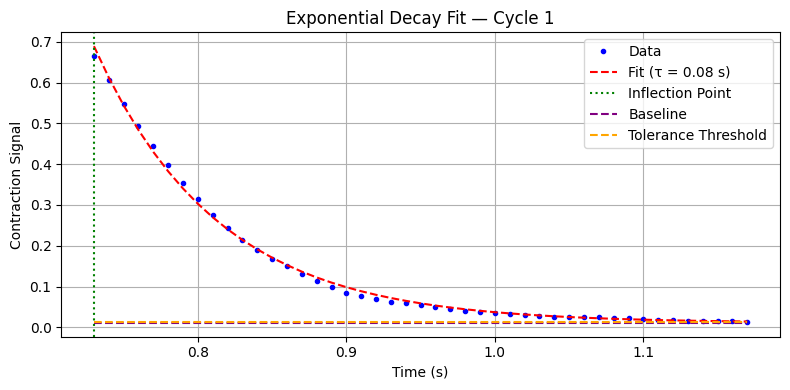

Cycle 1: τ = 0.083 s


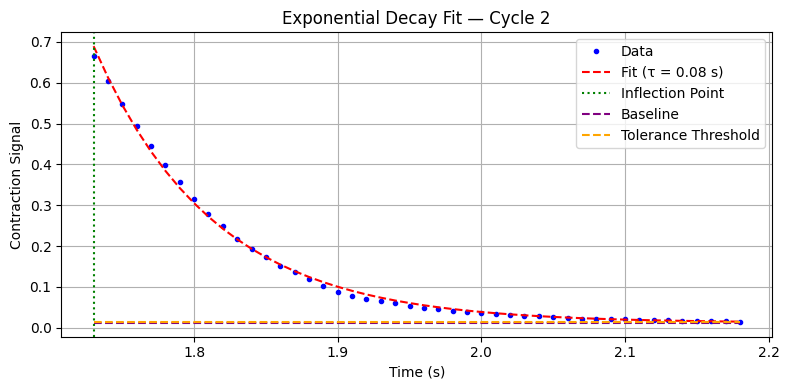

Cycle 2: τ = 0.083 s


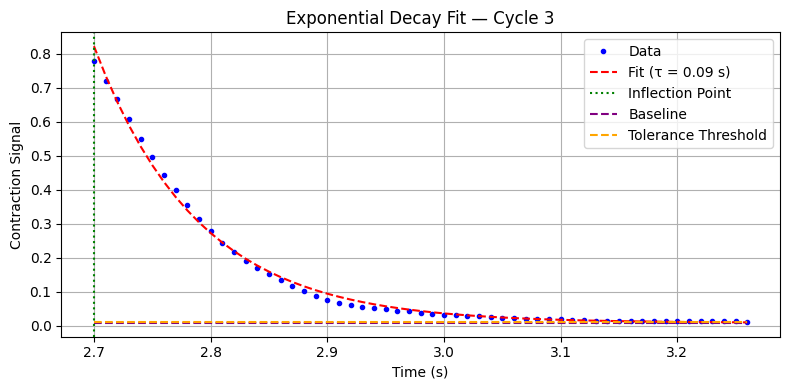

Cycle 3: τ = 0.089 s


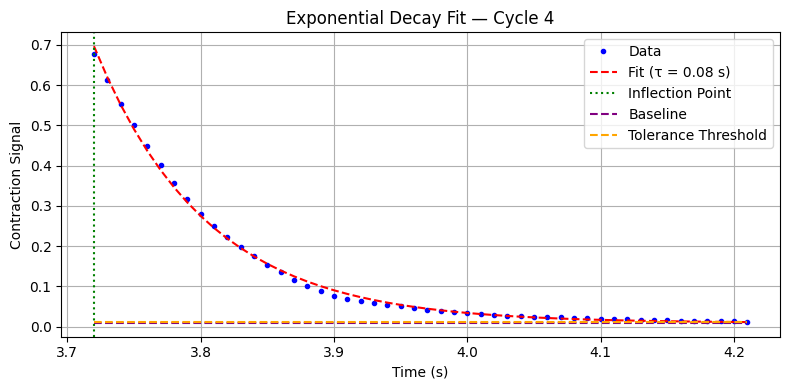

Cycle 4: τ = 0.084 s


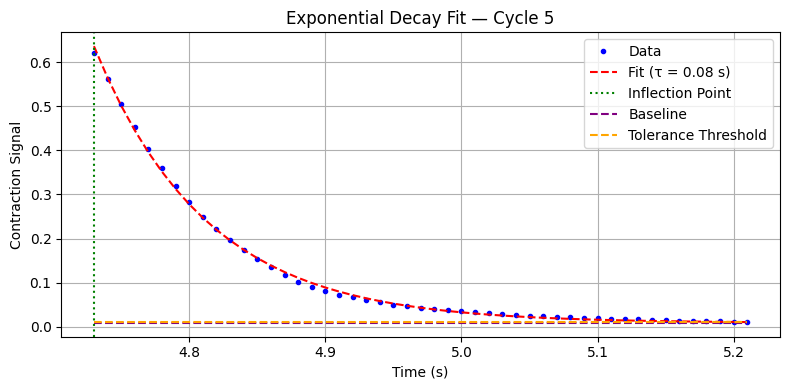

Cycle 5: τ = 0.083 s


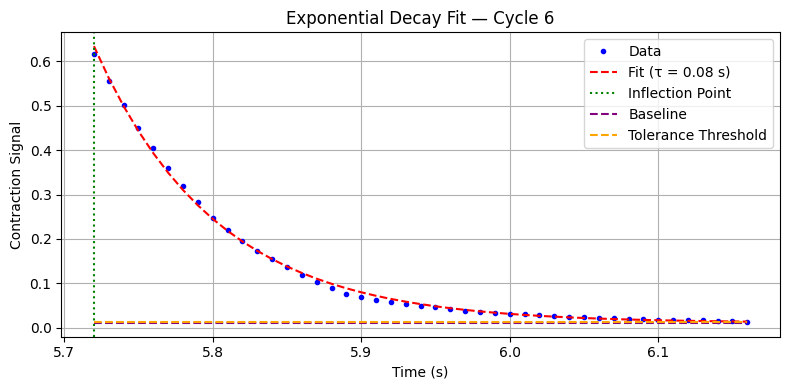

Cycle 6: τ = 0.082 s


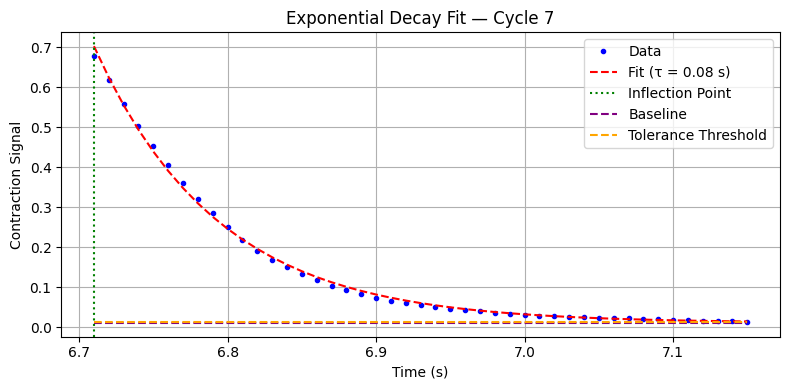

Cycle 7: τ = 0.083 s


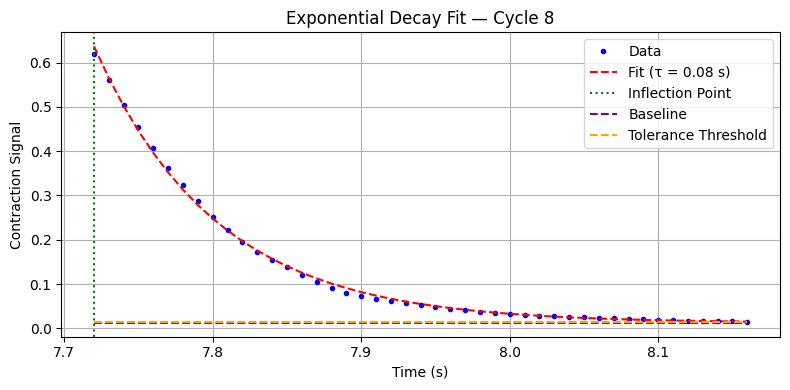

Cycle 8: τ = 0.082 s


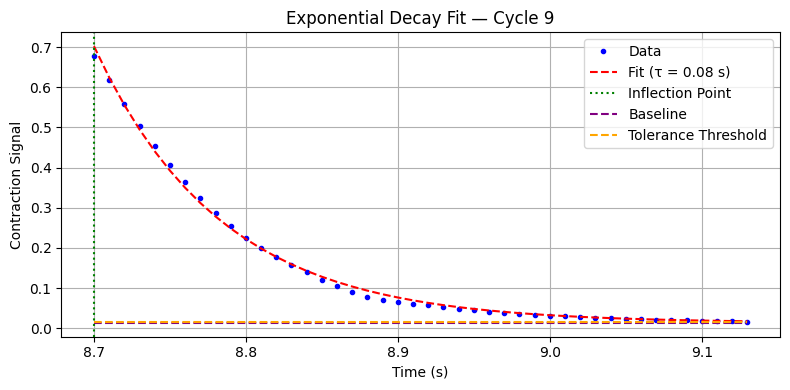

Cycle 9: τ = 0.084 s

Mean τ across cycles: 0.084 s


In [31]:
taus, mean_tau = compute_relaxation_time_constants_toactive(
    signal=filtered_full,
    time_vector=frame_time_point_sec,
    peaks=aligned_peaks,  # make sure aligned to valid cycles
    activation_idxs=activation_idxs,
    gradient_full=gradient_full,
    baseline_per_cycle=baseline_per_cycle,
    display_graphs=True,
    display_print=True
)


In [32]:
t90_duration = 2.3 * np.array(taus)
mean_t90_duration = np.mean(t90_duration)
print(t90_duration)
print(f"Mean t90 duration: {mean_t90_duration:.3f} s")

[0.19094184 0.19201058 0.20455085 0.19361362 0.1900873  0.18801426
 0.19184897 0.18857214 0.19256948]
Mean t90 duration: 0.192 s


In [66]:
def create_summary_excel_with_means(signal, time_vector, peaks, end_relax_idxs, start_activation_idx, output_filename="contraction_summary_with_means.xlsx"):
    
    bpm, freq_hz, _ = calculate_beating_rate(peaks, time_vector, display=False)
    
    baseline_per_cycle, baseline_pairs = compute_baseline_per_cycle(
    signal=filtered_full,
    time_vector=frame_time_point_sec,
    end_relax_idxs=end_relax_idxs,
    start_activation_idx=start_activation_idx,
    peaks=aligned_peaks,   # optional
    plot=False)

    amps, amps_90, mean_amp_90 = compute_relative_contraction_amplitudes_to_baseline(
    signal, aligned_peaks, baseline_per_cycle, threshold_percentage=0.9, display=False)
    
    ttp, mean_ttp = compute_time_to_peak(time_vector, aligned_peaks, start_activation_idx)
    
    t90r, mean_t90r = compute_peak_to_percent_relaxation_time(
    signal, time_vector, aligned_peaks, baseline_per_cycle, relax_percentage=0.9, display=False)
    
    taus, mean_tau = compute_relaxation_time_constants_toactive(signal, time_vector, peaks, activation_idxs,
                                      gradient_full, baseline_per_cycle,
                                      display_graphs=False, display_print=False)

    max_len = max(len(amps_90), len(ttp), len(t90r), len(taus))
    def pad(lst): return lst + [np.nan] * (max_len - len(lst))

    data = {
        "90% Amplitude (mN/mm²)": pad(amps_90),
        "Time to Peak (s)": pad(ttp),
        "Time to 90% Relaxation (s)": pad(t90r),
        "Tau (s)": pad(taus),
    }

    df = pd.DataFrame(data)
    df.loc["Mean"] = df.mean(numeric_only=True)

    meta = pd.DataFrame({
        "Parameter": [
            "Beating Rate (BPM)",
            "Frequency (Hz)",
            "Mean 90% Amplitude (mN/mm²)",
            "Mean Time to Peak (s)",
            "Mean Time to 90% Relaxation (s)",
            "Mean Tau (s)"
        ],
        "Value": [
            bpm,
            freq_hz,
            mean_amp_90,
            mean_ttp,
            mean_t90r,
            mean_tau
        ]
    })

    with pd.ExcelWriter(output_filename) as writer:
        meta.to_excel(writer, sheet_name="Summary", index=False)
        df.to_excel(writer, sheet_name="Per Cycle", index_label="Cycle")
    print(f'Excel with the parametes is prepered')
    return df, meta


In [69]:
base_name = os.path.splitext(file_name)[0]  # → 'stress_2HZ_4_flood_fill'
output_filename = f"contraction analysis parameters of {base_name}.xlsx"
df_cycles, df_summary = create_summary_excel_with_means(
    signal=filtered_full,
    time_vector=frame_time_point_sec,
    peaks=peaks,
    start_activation_idx=start_activation_idx,
    end_relax_idxs = end_relax_idxs,
    output_filename=output_filename
)

Excel with the parametes is prepered
